In [14]:
using NPZ
using Interpolations
using Cubature
using PyCall
using LinearAlgebra
using BenchmarkTools
# mpb = pyimport("meep.mpb")
# mp = pyimport("meep")
# @pyimport matplotlib.animation as anim
using PyPlot
using QuadGK
# using FFTW
# using Plots
# pyplot()
include("xray_3dphc.jl")
numpy = pyimport("numpy")

PyObject <module 'numpy' from '/home/elinas/miniconda3/envs/mp/lib/python3.7/site-packages/numpy/__init__.py'>

In [15]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
data = npzread("phc_an_files/phc1d_largek_kpar_tm_ga.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
# krange = -0.75:Δk:0.75
# krange = -0.5:Δk:0.5
krange = range(-0.5, 0.5, length=25)


M1dat = data["arr_1"]
M2dat = data["arr_2"]
# M3dat = data["arr_3"]
ωdat = data["arr_3"]
vgdat = data["arr_4"];

Nb = size(ωdat)[1]
NM = size(M1dat)[4]
Nk = size(ωdat)[2]
# ks = range(-0.75,0.75,length=70)
ks = range(-0.5,0.5,length=70);

In [16]:
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:]
#     avg = mean(ωband[ωband.!=0])
#     ωband[ωband.==0] .= avg
#     if ωdat[b,k0,k0,k0] == 0
#         ωband[k0,k0,k0] = 0
#     end
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
#     ωitp = interpolate(ωdat[b,:,:,:], BSpline(Linear()));
    ωsitp = scale(ωitp, krange, krange.*8);
    ωsplines[b] = ωsitp
end
Msplines = Array{Any,3}(undef, Nb, NM, 3)
for i in 1:2
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nz in 1:NM
            Mitp = interpolate(Mdat[b,:,:,nz], BSpline(Quadratic(Flat(OnCell()))));
            Msitp = scale(Mitp, krange, krange.*8);
            Msplines[b,nz,i] = Msitp
        end
    end
end
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [0,0,1]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
# a = 0.5e-6 #PhC lattice spacing
a = 0.5e-6 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.001
ϕdev = 0.0025

P = PumpBeam(1e19, θB, 0.0)
D_tm = PhC_Data(a, Msplines, ωsplines, 0);

In [17]:
ħ*np*ωp/(2*ϵ0)

5.985995030494693e9

In [18]:
function kB_func(ω,kp,ϵ1,ϵ2,d1,a,pol="te")
    d2 = a - d1;
    if (ϵ1*ω^2/c^2 - kp^2) >= 0 || ϵ2*ω^2/c^2 - kp^2 >= 0
        kz1 = sqrt(Complex(ϵ1*ω^2/c^2 - kp^2));
        kz2 = sqrt(Complex(ϵ2*ω^2/c^2 - kp^2));
        if pol == "tm"
            p = kz2/kz1;
        else
            p = ϵ1/ϵ2*kz2/kz1;
        end
        x = cos(kz1*d1)*cos(kz2*d2) - (1/2)*(p+1/p)*sin(kz1*d1)*sin(kz2*d2);
        if abs(x) < 1 && imag(x) == 0
            K = acos(x)/a;
            else 
            K = 0#NaN;
        end
    else
        K = 0#NaN
    end
    return K
end


function mode_coeffs_and_norm(ω,kp,ϵ1,ϵ2,d1,a,pol="te", kb=-1e9)
    k1 = sqrt(Complex(ϵ1*ω^2/c^2 - kp^2));
    k2 = sqrt(Complex(ϵ2*ω^2/c^2 - kp^2));
    if pol == "tm"
        p = k2/k1;
    else
        p = ϵ1/ϵ2*k2/k1;
    end
    if kb == -1e9
        kb = kB_func(ω,kp,ϵ1,ϵ2,d1,a,pol);
    end
    d2 = a - d1;
    M = [-exp(-1im*k1*d1) exp(1im*k2*d1) exp(-1im*k2*d1)
    exp(-1im*k1*d1) p*exp(1im*k2*d1) -p*exp(-1im*k2*d1)
    -exp(1im*kb*a) exp(1im*k2*a) exp(-1im*k2*a)]
    V = [exp(1im*k1*d1), exp(1im*k1*d1), exp(1im*kb*a)];
    coeffs = inv(M)*V;
    a1 = 1;
    b1 = coeffs[1];
    a2 = coeffs[2];
    b2 = coeffs[3];
    
    function F12(z)
        F1z = a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        F1z2 = ϵ1*abs(F1z)^2;
        return F1z2
    end

    function F22(z)
        F2z = a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        F2z2 = ϵ2*abs(F2z)^2;
        return F2z2
    end
    norm = sqrt(quadgk(F12,0,d1)[1] + quadgk(F22,d1,a)[1]);
    
   
    return coeffs, norm
end

function mode_coeffs_and_norm(ω,kp,ϵ1,ϵ2,d1,a,pol="te")
    k1 = sqrt(Complex(ϵ1*ω^2/c^2 - kp^2));
    k2 = sqrt(Complex(ϵ2*ω^2/c^2 - kp^2));
    if pol == "tm"
        p = k2/k1;
    else
        p = ϵ1/ϵ2*k2/k1;
    end
    kb = kB_func(ω,kp,ϵ1,ϵ2,d1,a,pol);
    d2 = a - d1;
    M = [-exp(-1im*k1*d1) exp(1im*k2*d1) exp(-1im*k2*d1)
    exp(-1im*k1*d1) p*exp(1im*k2*d1) -p*exp(-1im*k2*d1)
    -exp(1im*kb*a) exp(1im*k2*a) exp(-1im*k2*a)]
    V = [exp(1im*k1*d1), exp(1im*k1*d1), exp(1im*kb*a)];
    coeffs = inv(M)*V;
    a1 = 1;
    b1 = coeffs[1];
    a2 = coeffs[2];
    b2 = coeffs[3];
    
    function F12(z)
        F1z = a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        F1z2 = ϵ1*abs(F1z)^2;
        return F1z2
    end

    function F22(z)
        F2z = a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        F2z2 = ϵ2*abs(F2z)^2;
        return F2z2
    end
    norm = sqrt(quadgk(F12,0,d1)[1] + quadgk(F22,d1,a)[1]);
    
   
    return coeffs, norm
end



mode_coeffs_and_norm (generic function with 3 methods)

In [19]:
function dΓdωdΩ_1D_analytical(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14, pol="te")
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    ϵ1 = 12
    ϵ2 = 1

    kiz = -ks*sin(θs) - kp*sin(θp) + gvec[3]
    kiy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kB = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[1]
    k0z = kiz * a/(2π)
    k0y = kiy * a/(2π)
    k0x = (kB * a / (2π) + 100.5) % 1 - 0.5 # in MPB units
    
    noffset = -floor(kB*a/(2π) + 0.5) # g
    kpar = sqrt(kiz^2 + kiy^2)
    k0par = kpar *a/(2π)

    
    if abs(k0par) > 4 # we don't have enough data for that
#         return 0
        return 0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0
    end

    ωspline = D.ωspline[band]
    ω0 = ωspline(k0x, k0par)
    ωi = ω0 * 2π*c / (a*sqrt(ϵbg)) # ϵbg to be used for free space simulations; 1 otherwise
    
    if ϵ1*ωi^2/c^2 - kpar^2 < 0 && ωi^2/c^2 - kpar^2 < 0
        return 0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0
#         return 0
    end
    
    # do the mode integral analytically
    # but first get the mode coefficients numerically...
    coeffs, norm = mode_coeffs_and_norm(ωi, kpar, ϵ1, ϵ2, a/2, a, pol, k0x*2π/a)
    a1 = 1/norm
    b1 = coeffs[1]/norm
    a2 = coeffs[2]/norm
    b2 = coeffs[3]/norm
    
    
#     k1 = sqrt(Complex(ϵ1*ωi^2/c^2 - kpar^2))
    
#     Δkzp = gvec[1] + kp*cos(θp)*cos(ϕp) -ks*cos(θs)*cos(ϕs) + k1 #+ noffset * 2π/a
#     Δkzm = gvec[3] + kp*cos(θp)*cos(ϕp) -ks*cos(θs)*cos(ϕs) - k1 #+ noffset * 2π/a
    k1 = sqrt(Complex(ϵ1*ωi^2/c^2 - kpar^2))
    k2 = sqrt(Complex(ωi^2/c^2 - kpar^2))
    
    # Julia uses the normalized sinc function
    g = -2π*noffset/a
#     if kB_c == 0
#          return 0,0,0,0,0,kpar,0,0,0,0,0, 0, ωi, 0, 0, 0
#     end
    
#     M2 = abs(a1*sinc(a*(k1+g)/(8π)) + b1*sinc(a*(k1-g)/(8π)))^2/norm^2
    kb_c = kB_func(ωi,kpar,ϵ1,ϵ2,a/2,a, pol)
    zs = range(0, 31*a/64, length=32)
#     if real(kb_c) > 0 && abs(real(kb_c) - abs(k0x*2π/a)) > 1e5
#         kb_c = kb_c * sign(k0x)
#         M2 = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, kb_c, pol=pol)*exp(-2im*π*noffset/a*z), 0, a/2)[1])^2/a
#     else
#         M2 = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol)*exp(-2im*π*noffset/a*z), 0, a/2)[1])^2/a
#     end
    M2 = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol)*exp(2im*π*noffset/a*z), 0, a/2)[1])^2/a
#     M2_abs = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, abs(k0x*2π/a), pol=pol)*exp(2im*π*noffset/a*z), 0, a/2)[1])^2/a

#     M2 = (abs(sum(efield_fast.(zs, ωi, kpar, a, ϵ1, a1, b1, a2, b2, k1, k1, pol).*exp.(-2im*π*zs*noffset/a)))*a/64)^2/(a)
#     M2 = abs(sum((a1*exp.(1im*(k1+g)*zs) + b1*exp.(-1im*(k1-g)*zs)))*a/64)^2/a
    
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2 #* a/2
#     polfactor = (1-(kix/sqrt(kpar^2+kB^2)))^2
    if pol == "te"
        polfactor = abs(sum(normalize([kB, kiy, kiz]).*normalize(gvec)))^2
    else
        polfactor = 1 - abs(sum(normalize([kB, kiy, kiz]).*normalize(gvec)))^2
    end

#     m2_list = [abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol)*exp(2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a)
#     m2_list_slow = [abs(quadgk(z -> efield(z, ωi, kpar, a, 5.3, pol=pol)*exp(2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a)
    efield_list = [efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol) for z in range(0, a*511/512, length=512)]
#     efield_slow = [efield(z, ωi, kpar, a, 5.3, pol) for z in range(0, a*511/512, length=512)]
    dΓdωdΩ = prefactor * ωi * M2 * lor(ωp - ωs - ωi, lz) * polfactor 
    return kB, M2, k1, Ep2, kB, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, lor(ωp - ωs - ωi, lz), efield_list
#     return dΓdωdΩ
end

dΓdωdΩ_1D_analytical (generic function with 2 methods)

In [20]:
# 0 to a/2 in the unit zone is the dielectric, the rest (a/2-a) is air
# inputs are in physical units, not MPB units
function efield(z, ω, kp, a, ϵ, pol="te", bloch_phase=false)
    coeffs, norm = mode_coeffs_and_norm(ω,kp,ϵ,1,a/2,a,pol)
    a1 = 1/norm
    b1 = coeffs[1]/norm
    a2 = coeffs[2]/norm
    b2 = coeffs[3]/norm
    k1 = sqrt(Complex(ϵ*ω^2/c^2 - kp^2))
    k2 = sqrt(Complex(ω^2/c^2 - kp^2))
    kB_c = kB_func(ω,kp,5.3,1.0,a/2,a,pol)
    if bloch_phase
        if (floor(2*z/a) % 2) == 0
            return a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        else
            return a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        end
    else
        if (floor(2*z/a) % 2) == 0
            return (a1*exp(1im*k1*z) + b1*exp(-1im*k1*z))*exp(-1im*kB_c*z)
        else
            return (a2*exp(1im*k2*z) + b2*exp(-1im*k2*z))*exp(-1im*kB_c*z)
        end
    end
end

efield (generic function with 3 methods)

In [21]:
function efield_fast(z, ω, kp, a, ϵ, a1, b1, a2, b2, k1, k2, kB; pol="te", bloch_phase=false)
    if bloch_phase == true
        if (floor(2*z/a) % 2) == 0
            return a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        else
            return a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        end
    else
         if (floor(2*z/a) % 2) == 0
            return (a1*exp(1im*k1*z) + b1*exp(-1im*k1*z))*exp(-1im*kB*z)
        else
            return (a2*exp(1im*k2*z) + b2*exp(-1im*k2*z))*exp(-1im*kB*z)
        end
    end
    
end

efield_fast (generic function with 1 method)

In [10]:
function ft_slow(in_arr)
    n = size(in_arr)[1]
    out_arr = Array{Any,1}(undef, n)
    for k in 1:n
        out_arr[k] = 0
    end
    for m in 1:n
        for k in 1:n
            out_arr[k] += in_arr[m]*exp(-2im*π*(m*k/n))
        end
    end
    return abs.(out_arr)
end

ft_slow (generic function with 1 method)

In [11]:
k0z = k0xa
k0p = k0para
# k0z = 0.3
# k0p = 0.3
kip = k0p*2*π/a
band = 1
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
ωi*ħeV

LoadError: UndefVarError: k0xa not defined

In [111]:
coeffs, n = mode_coeffs_and_norm(ωi,kip,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;

LoadError: MethodError: no method matching ^(::Array{Float64,1}, ::Int64)
Closest candidates are:
  ^(!Matched::Irrational{:ℯ}, ::Integer) at mathconstants.jl:91
  ^(!Matched::Irrational{:ℯ}, ::Number) at mathconstants.jl:91
  ^(!Matched::Float16, ::Integer) at math.jl:915
  ...

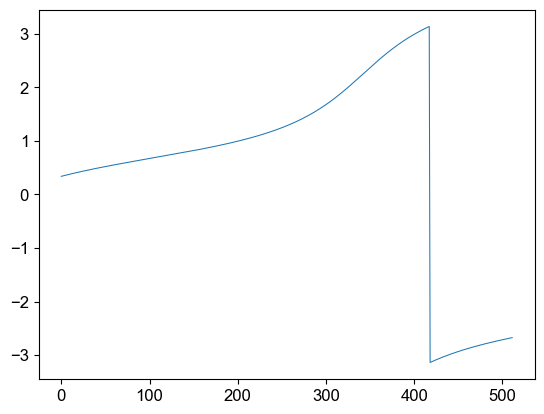

1.3483312263100868e7 + 0.0im


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f756266e710>

In [101]:
println(k1)
plot(angle.(a1*exp.(1im*k1*zs) + b1*exp.(-1im*k1*zs)))

In [102]:
println(coeffs)
println(n)
println("a1: ", a1)
println("b1: ", b1)
println("a2: ", a2)
println("b2: ", b2)

Complex{Float64}[0.08046341575643695 + 0.38068806491776824im, 2.5603534230633813 + 1.274114196871592im, -0.43377201783024705 + 0.15514070234556138im]
0.001584209208738419
a1: 631.2297608699974
b1: 50.79090268671888 + 240.3016361841049im
a2: 1616.1712789829776 + 804.2587998123239im
b2: -273.8098070870831 + 97.92942844279216im


In [106]:
numz = 512
zs = range(0, a*(numz-1)/(2*numz), length=numz)
Δz = zs[2] - zs[1]
k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
# plot(angle.(efield.(zs, ωi, kip, a, 5.3,"tm").*exp(1im*Δϕ)))#*sqrt(a))
kBc = kB_func(ωi, kip, 5.3, 1, a/2 , a, "tm")
# E_1 = npzread("phc_an_files/phc1d_modes.npz")["arr_0"]
# E_1b = npzread("phc_an_files/phc1d_modes.npz")["arr_1"]
E_1 = npzread("phc_an_files/phc1d_modes_kpar--0.3_tm.npz")["arr_0"]
E_1b = npzread("phc_an_files/phc1d_modes_kpar--0.3_tm.npz")["arr_1"]
# E_1 = npzread("phc_an_files/phc1d_modes_kpar-0.299_k0x--0.385_tm.npz")["arr_0"]
# E_1b = npzread("phc_an_files/phc1d_modes_kpar-0.299_k0x--0.385_tm.npz")["arr_1"]


# Δϕf = angle(E_1[band,3,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))
Δϕf = angle(E_1[1,3,1,1,1]) - angle(efield_fast(zs[1], ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kB_ca, pol="tm"))

# plot(angle.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm", bloch_phase=false)))
plot(angle.(efield.(zs, ωi, kip, a, 5.3, "tm")))
# plot(abs.(efield.(zs, ωi, kip, a, 5.3,"tm"))*sqrt(a))


plot(angle.(E_1[1,3,1:512,1,1]))


# println(angle(efield(zs[64], ωi, kip, a, 5.3,"tm", true)) - angle(efield(zs[1], ωi, kip, a, 5.3,"tm", true)))
# kB_c = (angle(efield(zs[64], ωi, kip, a, 5.3,"tm", true)) - angle(efield(zs[1], ωi, kip, a, 5.3,"tm", true)))/a

LoadError: MethodError: no method matching ^(::Array{Float64,1}, ::Int64)
Closest candidates are:
  ^(!Matched::Irrational{:ℯ}, ::Integer) at mathconstants.jl:91
  ^(!Matched::Irrational{:ℯ}, ::Number) at mathconstants.jl:91
  ^(!Matched::Float16, ::Integer) at math.jl:915
  ...

In [107]:
kBc

3.794734458561204e6 + 0.0im

In [187]:
s1 = sum(abs.(efield_fast.(zs[1:255], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm", bloch_phase=true)).^2)*Δz
s2 = sum(abs.(efield_fast.(zs[256:512], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm", bloch_phase=true)).^2)*Δz
s1*5.3+s2

0.9977884360229705

In [52]:
e_ft = ft_slow(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))

1024-element Array{Float64,1}:
 122444.56194422925
  23915.036115541177
   3816.7483834840405
   3305.6747237347486
    908.9322393496459
   1042.8003971761916
    349.40105393207733
    456.5431946495118
    169.87706581993484
    239.46462160412372
     95.12085584641117
    140.94423183292852
     58.54775541403385
      ⋮
    121.65417459079899
    307.87668786965
    229.63137529339016
    625.7041406919508
    515.6954069283138
   1592.5469005996665
   1577.4065867149468
   6328.748084907791
   9978.185141499247
 108322.04124750536
 787667.4694417525
 389041.7312634147

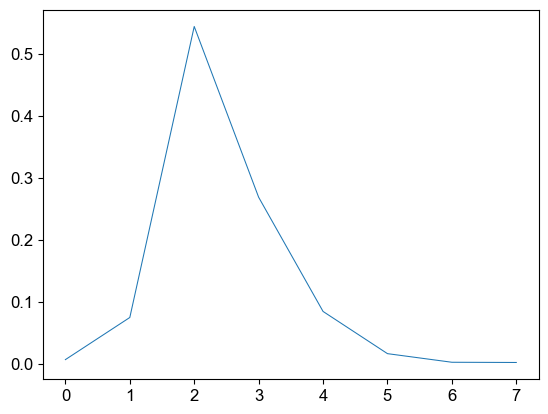

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f069e2924d0>

In [53]:
plot(numpy.fft.fftshift(e_ft)[512-3:512+4]/1024*sqrt(a))

In [54]:
M_an = Array{Any,1}(undef, 7)
for n in -3:3
    M_an[n + 4] = quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm")*exp(-2im*π*n/a*z), 0, a/2)[1]/sqrt(a)
end

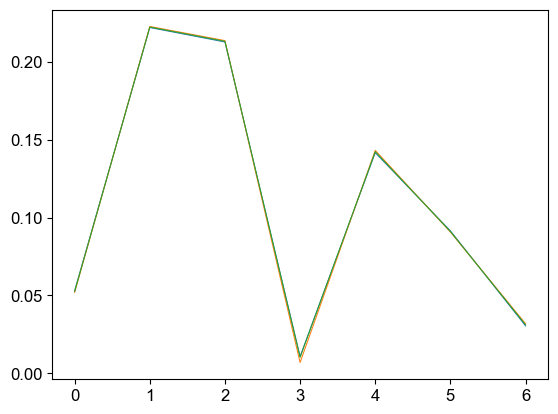

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f07009d3350>

In [55]:
band = 2
k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
# kB_c = kB(ωi,kip,5.3,1.0,a/2,a,"tm")
# M_1_y = npzread("phc_an_files/phc1d_M_1_y.npz")["arr_0"]
M_1_z = npzread("phc_an_files/phc1d_M_1_z_kpar-0.3.npz")["arr_0"]

# plot([abs(quadgk(z -> efield(z, ωi, kip, a, 5.3,"tm")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot([abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
# plot([abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm", bloch_phase=true)*exp(-2im*π*n/a*z-2im*Δϕf), 0, a/2)[1]) for n in -3:3]/sqrt(a))
# plot(M_an)
# plot([abs(sum(E_1[band,2,:,1,1].*exp.(-2im*π*zs*n/a))) for n in -3:3]/(2*numz))
plot([D_tm.Mspline[band,n,2](k0z, k0p) for n in 1:7])
plot(M_1_z)
# plot([abs(a1*sinc(a/2*(k1-2*π*n/a)/(2π)) + b1*sinc(a/2*(k1+2*π*n/a)/(2π)))*sqrt(a)/2 for n in -3:3])

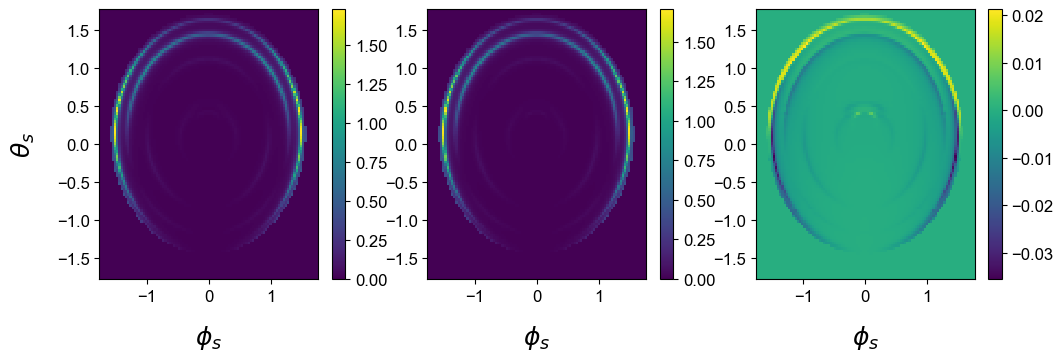

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5bed2e1790>

In [22]:
ωi = 3.0/ħeV #2/ħeV
Nangles = 100
θdev = 0.00175
ϕdev = 0.00175
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
b = 4
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:6
    newdat = [dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
# ωi, M0^2, lor, kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par
# dat = [dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")
#                         for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

subplot(1,3,2)
# 1   2   3   4    5     6      7   8     9      10    11    12     13  14
# kB, M2, k1, Ep2, kB_c, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, lor
# dat2 = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[9]
#                             for θs in θrange, ϕs in ϕrange]

dat2 = zeros(Nangles, Nangles)
# Threads.@threads for b in 1:6
#     newdat = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[12]*cos(θs)
#                             for θs in θrange, ϕs in ϕrange]
#     global dat2 .+= newdat
# end
Threads.@threads for b in 1:6
    newdat = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[12]*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat2 .+= newdat
end
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


subplot(1,3,3)
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2 .- dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

In [51]:
println(sum(dat))
println(sum(dat2)/2)

380.7209500203146
408.24774092130434


## Testing
now obsolete- fixed

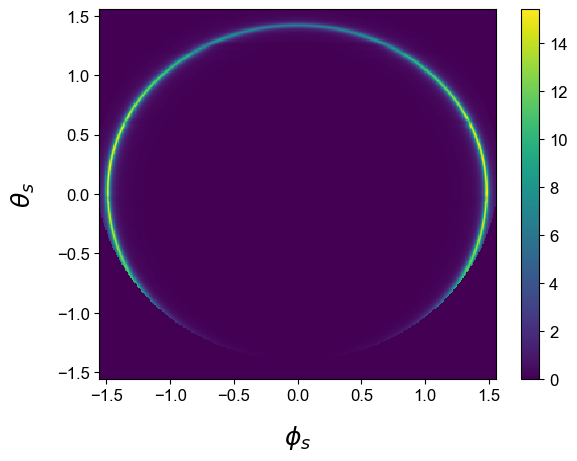

PyObject <matplotlib.colorbar.Colorbar object at 0x7f91a39cb690>

In [38]:
ωi = 4.0/ħeV #2/ħeV
Nangles = 300
θdev = 0.00155
ϕdev = 0.00155
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
# b = 4
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:6
    newdat = [(dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm"))
#               + dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_te, χ, np, L, b, lz=0.6e14, pol="te")*cos(θs))
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# npzwrite("phc_an_files/ang_spec_1d_ln_1-6.npz", dat)

pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)

xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

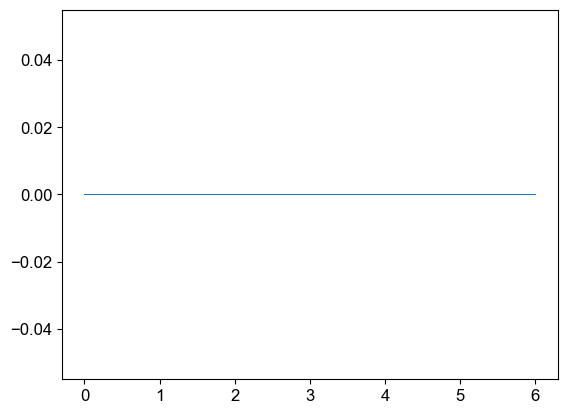

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f91b3de4750>

In [33]:
plot([D_tm.Mspline[2, i,1](0.3,1) for i in 1:7])

In [196]:
θB

0.29662806479241327

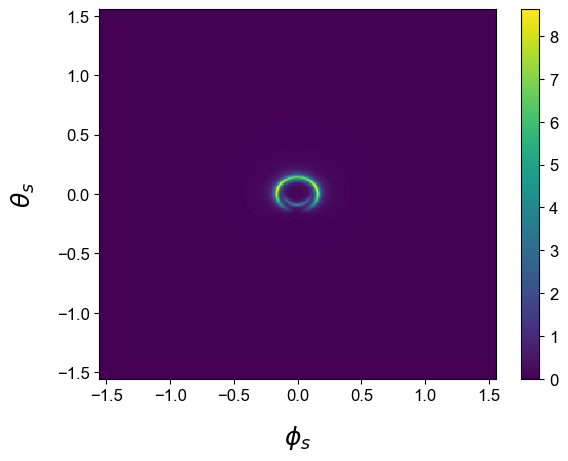

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5f1dadf450>

In [13]:
ωi = 0.6/ħeV #2/ħeV
Nangles = 300
θdev = 0.00155
ϕdev = 0.00155
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
# b = 4
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:6
    newdat = [(dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs)
              + dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_te, χ, np, L, b, lz=0.6e14, pol="te")*cos(θs))
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# npzwrite("phc_an_files/ang_spec_1d_ga_0-6.npz", dat)
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

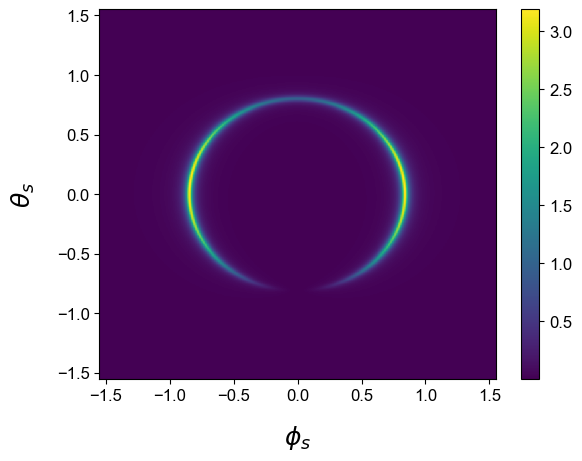

PyObject <matplotlib.colorbar.Colorbar object at 0x7fee17046190>

In [195]:
ωi = 1.6/ħeV #2/ħeV
Nangles = 600
θdev = 0.00155
ϕdev = 0.00155
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:1
    newdat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, lz=0.6e14, pol="tm")*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
npzwrite("phc_an_files/ang_spec_fs_1d_ga_1-6.npz", dat)

pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

In [197]:
npzwrite("phc_an_files/ang_spec_1d_ga_thrange.npz", θrange)
npzwrite("phc_an_files/ang_spec_1d_ga_phrange.npz", ϕrange)

In [32]:
ωi = 3.2/ħeV #2/ħeV
Nangles = 50
θdev = 0.00125
ϕdev = 0.00125
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
b = 1
ϕ = 0.0
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
# Threads.@threads for b in 2:2
#     newdat = [(info_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, 5.3, lz=0.6e14, pol="tm")[2])
# #               + dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_fs_tm, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs))
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end

# ωi, M0^2, lor, kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par
info_m = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[i]
                        for i in 1:11, θs in θrange]
dat = info_m[2, :]
ωim = info_m[1, :]
k0xm = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[5]
                        for θs in θrange]
noffsetm = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[6]
                        for θs in θrange]

kBm = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[4]
                        for θs in θrange]

# 1   2   3   4    5     6      7   8     9      10    11    12     13   14
# kB, M2, k1, Ep2, kB_c, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, lor
info_an = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:14, θs in θrange]
m2sa = info_an[2, :]
ωisa = info_an[13, :]
kparsa = info_an[6, :]
# m2a = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[2]
#                         for θs in θrange]
noffseta = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[9]
                        for θs in θrange]
k0xsa =  [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[10]
                        for θs in θrange]
kba =  [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[1]
                        for θs in θrange]
kbca =  [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[5]
                        for θs in θrange];



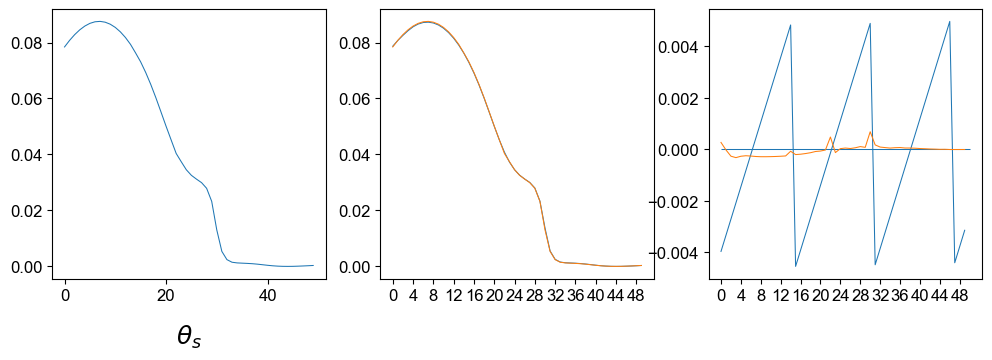

In [33]:
subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
plot( dat)
xlabel(L"$θ_s$", fontsize=18.0, labelpad=14)

subplot(1,3,2)
plot(m2sa)
# plot(m2sabs_a)

# plot(kbca*a/(2π)*0.1)
plot(dat)
# plot((kB_func.(ωisa, kparsa, 5.3, 1, a/2, a, "tm").- abs.(k0xsa*2π/a))*1e-8)
# plot(noffseta)
# plot(k0xa)
# plot(k0xm)
# plot(kba*a/(2π))
xticks(0:4:50);

subplot(1,3,3)
# plot([kB_func(ωisa[i], kparsa[i], 5.3, 1, a/2, a, "tm") for i in 1:50])
# plot(k0xsa)
plot(k0xm/100)

# plot([kB_func(ωisa[i], kparsa[i], 5.3, 1, a/2, a, "tm") for i in 10:40] .- abs.(k0xsa[10:40]*2π/a))
# plot(dat[10:40] .- m2sa[10:40])
xticks(0:4:50);

plot((m2sa .- dat))
hlines(0, 0, 50)
# plot(noffseta*1e6)
# plot(ωisa)
# plot(ωim)
# plot(k0xa)
# plot(kba*a/(2π))
# plot(kBm*a/(2π))
# xticks(0:11, 5:16);

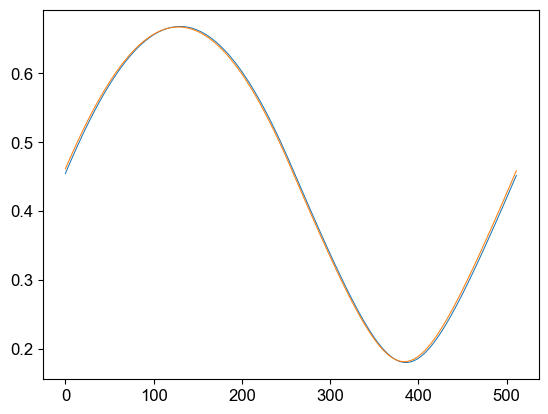

k0x = -0.4482942412381874
k0par = 0.17936303553758165


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5f02a88590>

In [37]:
# Look at a place where there is a discrepancy between M2 in the analytical and MPB solutions
θsd = θrange[32]
ϕsd = 0.0
b = 1
# get all the data for the analytical and mpb solutions
# 1   2   3   4    5     6      7   8     9      10    11    12     13      14     15    16 
# kB, M2, k1, Ep2, kB_c, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, m2_list, efield, lor
data_a = dΓdωdΩ_1D_analytical(ωp - ωi, θsd, ϕsd, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")
println("k0x = $(data_a[10])")
println("k0par = $(data_a[11])")
#  1    2    3    4   5      6       7        8       9    10   11
# ωi, M0^2, lor, kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par
data_m = info_1D(ωp - ωi, θsd, ϕsd, gvec, P, D_tm, χ, np, L, b)
# load the MPB-generated modes
efield_m = npzread("phc_an_files/phc1d_modes_k0x--0.44829_k0par-0.17936_b-1_tm.npz")["arr_0"]
efield_mb = npzread("phc_an_files/phc1d_modes_k0x--0.44829_k0par-0.17936_b-1_tm.npz")["arr_1"]

# efield_mu = npzread("phc_an_files/phc1d_modes_k0x--0.448294_k0par-0.179363_b-1_tm_u.npz")["arr_0"]
plot(abs.(data_a[15])*sqrt(a))
plot(abs.(efield_m[1,3,1:512,1,1]))
# plot(abs.(efield_m[1,3,1:512,1,1]) .- abs.(data_a[15])*sqrt(a))

# plot(angle.(data_a[15]))
# plot(angle.(efield_m[1,3,1:512,1,1]))
# plot(angle.(efield_mu[1,3,1:512,1,1]))

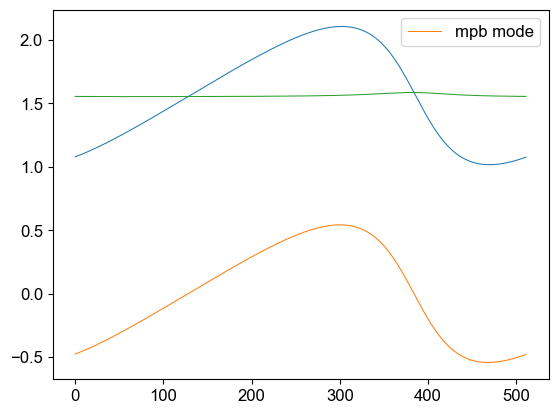

PyObject <matplotlib.legend.Legend object at 0x7f5f127a8210>

In [38]:
# get the mode coefficients
ωia = data_a[13]
kpara = data_a[6]
k0xa = data_a[10]
coeffs, n = mode_coeffs_and_norm(data_a[13],data_a[6],5.3,1,a/2,a,"tm", k0xa*2π/a)
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;
zs = range(0, a*511/512, length=512)
k1a = sqrt(Complex(5.3*ωia^2/c^2 - kpara^2))
k2a = sqrt(Complex(ωia^2/c^2 - kpara^2))
# Δϕ = angle(efield_mb[1,3,1,1,1]) - angle(conj(efield(zs[1], ωia, kpara, a, 5.3, "tm", true)))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2a, k0xa*2π/a, pol="tm", bloch_phase=false)))


# plot(angle.(conj.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2a, k0xa*2π/a, pol="tm", bloch_phase=true)).*exp.(-k0xa*2im*π/a*zs)), label="efield fast")
# plot(angle.(conj.(efield.(zs, ωia, kpara, a, 5.3, "tm", true)).*exp.(-k0xa*2im*π/a*zs)), label="efield")
plot(angle.(efield_m[1,3,1:512,1,1]), label="mpb mode")

plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2a, k0xa*2π/a, pol="tm", bloch_phase=false)).-angle.(efield_m[1,3,1:512,1,1]))
# plot(angle.(efield_m[1,3,1:512,1,1]), label="mpb mode")

legend()


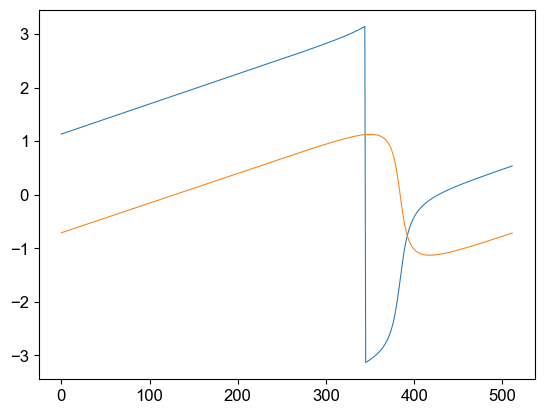

k0x = -0.4545565317555571
k0par = 1.7385060990099221


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fee15f58e10>

In [64]:
# Look at another place where there is a discrepancy between M2 in the analytical and MPB solutions
θsd = θrange[16]
ϕsd = 0.0
b = 1
# get all the data for the analytical and mpb solutions
# 1   2   3   4    5     6      7   8     9      10    11    12     13      14     15    16 
# kB, M2, k1, Ep2, kB_c, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, m2_list, efield, lor
data_a = dΓdωdΩ_1D_analytical(ωp - ωi, θsd, ϕsd, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")
println("k0x = $(data_a[10])")
println("k0par = $(data_a[11])")
#  1    2    3    4   5      6       7        8       9    10   11
# ωi, M0^2, lor, kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par
data_m = info_1D(ωp - ωi, θsd, ϕsd, gvec, P, D_tm, χ, np, L, b)
# load the MPB-generated modes
efield_m = npzread("phc_an_files/phc1d_modes_k0x--0.454556_k0par-1.738506_b-1_tm.npz")["arr_0"]
plot(angle.(data_a[15]))
plot(angle.(efield_m[1,3,1:512,1,1]))

# plot(abs.(data_a[15])*sqrt(a))
# plot(abs.(efield_m[1,3,1:512,1,1]))

In [283]:
#why are there places where there are no modes according to kb_func but there are according to MPB?
info_m = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:11, θs in θrange]
ωim, M2m, lorm, kBm, k0xm, noffsetm, kivecm, polfactorm, k0ym, kizm, k0parm = info_m[:, 32]
# kBa, M2a, k1a, Ep2a, kB_ca, kpara, a1a, b1a, noffseta, k0xa, k0para, dΓdωdΩa, ωia, m2_lista, efielda, lora = info_an[:, 31]
# println(kB_ca)
println("kb func: ", kB_func(ωia, kpara, 5.3, 1, a/2, a,"tm"))
println("kpara: ", kpara)
println("k0parm: ", k0parm)
println(kBm)
println(ωim)
println("ωi mpb: ", ωim*a/(2π*c))

kb func: 5.684192067766578e6 - 0.0im
kpara: 2.253942379081726e6
k0parm: 0.17936303553758165
1.9499309649036407e7
9.175804895876875e14
ωi mpb: 0.24356465583231351


k0xa: -0.196484068642107 k0xm: -0.4482942412381874
k0para: 0.6587019194706539 k0parm: 0.17936303553758165
-2.0


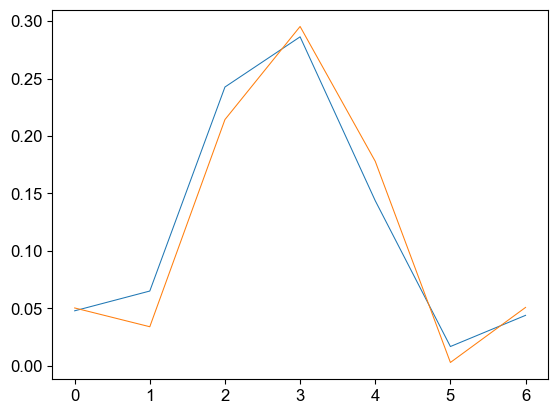

0.0028466755654479856
0.02324257575088054


In [285]:
# compare electric field at an inconsistent point
info_an = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:17, θs in θrange]
kBa, M2a, k1a, Ep2a, kB_ca, kpara, a1a, b1a, noffseta, k0xa, k0para, dΓdωdΩa, ωia, m2_lista, efielda, lora, M2_abs = info_an[:, 36]
println("k0xa: ", k0xa, " k0xm: ", k0xm)
println("k0para: ", k0para, " k0parm: ", k0parm)
println(noffseta)
# plot([abs(quadgk(z -> efield_fast(z, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, k0xa*2π/a, pol="tm")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot(m2_lista)
plot([D_tm.Mspline[b,n,2](k0xa, k0para) for n in 7:-1:1])
# plot(dΓdωdΩ_1D_analytical(ωp - ωi, θrange[17], 0., gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm"))
# plot()
println(D_tm.Mspline[b,Integer(noffseta + 4),2](k0xa, k0para))
println(dat[30])


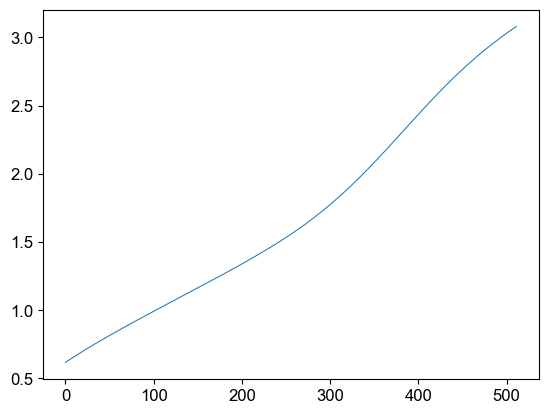

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f341ba46190>

In [289]:
plot(angle.(efielda))

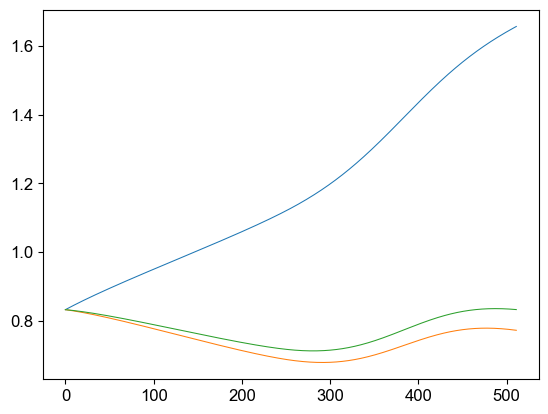

765643.4676025783 - 0.0im
-886460.6802144292


In [290]:
coeffs, n = mode_coeffs_and_norm(ωia,kpara,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;
kb_c = kB_func(ωia, kpara, 5.3, 1, a/2, a,"tm")
k2 = sqrt(Complex(ωia^2/c^2 - kpara^2))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, k0xa*2π/a, pol="tm", bloch_phase=false)))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, -(k0xa*2π/a), pol="tm", bloch_phase=false)))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, kb_c, pol="tm", bloch_phase=false)))

# plot(angle.(efield.(zs, ωia, kpara, a, 5.3, "tm",false)))
# plot(angle.(efielda))
println(kb_c)
println(k0xa*2π/a)

In [259]:
angle(efield_fast(zs[1], ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, kb_c, pol="tm", bloch_phase=false)) - angle(efield_fast(zs[512], ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, kb_c, pol="tm", bloch_phase=false))

-0.00023143991205698544

In [218]:
# M2a - info_1D(ωp - ωi, θrange[16], 0., gvec, P, D_tm, χ, np, L, b)[2]
println(M2a)
println(info_1D(ωp - ωi, θrange[16], 0., gvec, P, D_tm, χ, np, L, b)[2])

0.018017826086245366
0.07308740604315132


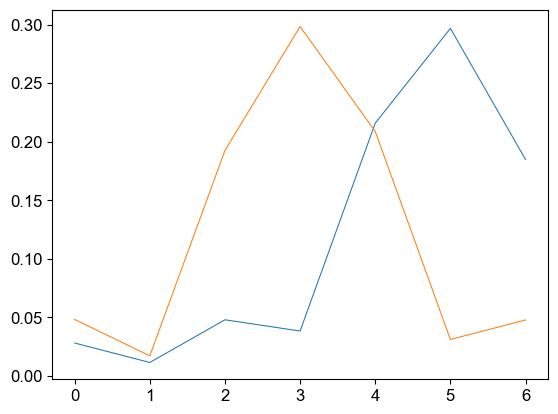

-2.0

In [286]:
# now for a consistent point
info_an = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, 0., gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:13, θs in θrange]
kBa, M2a, k1a, Ep2a, kB_ca, kpara, a1a, b1a, noffseta, k0xa, k0para, dΓdωdΩa, ωia = info_an[:, 38]
plot([abs(quadgk(z -> efield_fast(z, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kB_ca, pol="tm")*exp(2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot([D_tm.Mspline[b,n,2](k0xa, k0para) for n in 1:7])
noffseta


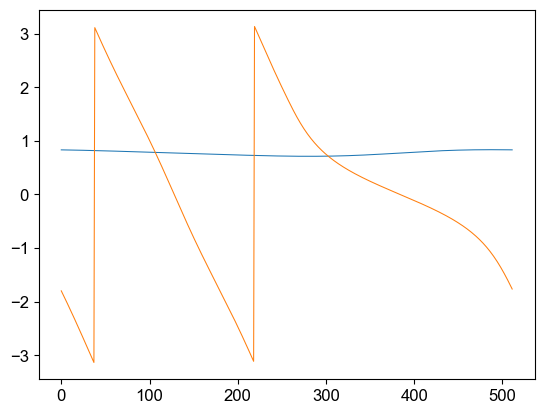

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f34194b38d0>

In [287]:
numz = 512
zs = range(0, a*(numz-1)/(numz), length=numz)
Δz = zs[2] - zs[1]
E_1 = npzread("phc_an_files/phc1d_modes_k0x--0.19648_k0par-0.65870_b-4_tm.npz")["arr_0"]
# E_1b = npzread("phc_an_files/phc1d_modes_kpar-0.299_k0x--0.385_tm.npz")["arr_1"]
# E_1 = npzread("phc_an_files/phc1d_modes_kpar-0.3_tm.npz")["arr_0"]


# Δϕf = angle(E_1[band,3,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))
Δϕf = -angle(E_1[4,3,1,1,1]) - angle(efield_fast(zs[1], ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, k0xa*2π/a, pol="tm"))

# plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, k0xa*2π/a, pol="tm", bloch_phase=false)))
# plot(angle.(efielda.*exp(1im*Δϕf)))
plot(angle.(efield.(zs, ωia, kpara, a, 5.3, "tm", false)))

# plot(abs.(efielda))# plot(real.(efield_fast.(zs, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kB_ca, pol="tm", bloch_phase=false))*sqrt(a))

# plot(abs.(efield.(zs, ωi, kip, a, 5.3,"tm"))*sqrt(a))


plot(-angle.(E_1[4,3,1:512,1,1]))

In [79]:
k0xa

-0.07054229955636515

In [153]:
sum(abs.(efield_fast.(zs, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kB_ca, pol="tm", bloch_phase=false)).^2)*Δz

0.3114532470012722

In [238]:
println(k0xa)
println(k0para)

0.32836335269280426
2.323591234501343


In [39]:
θs = θrange[33]
ϕs = 0.0
ωim, M2m, lorm, kBm, k0xm, noffsetm, kivecm, polfactorm, k0ym, kizm, k0parm = info_1D(ωp - ωi, θs, 0., gvec, P, D_tm, χ, np, L, b)

kBa, M2a, k1a, Ep2a, kBca, kpara, a1a, b1a, noffseta, k0xa, k0pa, dΓdωdΩa, ωia = dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, 1, lz=0.6e14, pol="tm")
println("M2a $(M2a)")
println("M2m $(M2m)")
println(D_tm.Mspline[1,Integer(noffseta+4),2](k0xa, k0pa)^2)
println(D_tm.Mspline[1,Integer(-noffseta+4),2](k0xm, k0parm)^2)
println("noffseta $(noffseta)")
println("noffsetm $(noffsetm)")

println(M2a - M2m)
println("integral: $(abs(quadgk(z -> conj(efield_fast(z, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kBca, pol="tm"))*exp(2im*π*noffseta/a*z), 0, a/2)[1])^2/a)")

M2a 0.00011248420200881984
M2m 0.002416080333209219
0.0001288716322251667
0.002416080333209219
noffseta -2.0
noffsetm -2.0
-0.0023035961312003993
integral: 0.0025464852786884476


In [169]:
#mismatch point
θs = θB -0.75e-3
ϕs = 0.0e-3
println(dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_fs_ln_tm, χ, np, L, 1, 5.3, lz=0.6e14, pol="tm"))
println(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 5.3, χ, np, L, lz=0.6e14, pol="tm"))

4.828088193206151e-12
1.6767927690368996e-10


In [170]:
ωi_phc, M02, lz, kBval, k0x, noffset, kivec, polfactor, k0y, kiz, kpar = info_1D(ωp - ωi, θs, ϕs, gvec, P, D_fs_ln_tm, χ, np, L, 1, 5.3, lz=0.6e14, pol="tm")
prefactor_fs, ωi_fs, lz_fs, idler_pol, polcalc, kivec_fs, sumkpg = info_free(ωp - ωi, θs, ϕs, gvec, P, 5.3, χ, np, L, lz=0.6e14, pol="tm")

(1.0612363381476586e-7, 3.345394387480963e15, 7.528347584257093e-18, 0.06273650109869944, 0.9372634989013003, [-6.434656473773956e6, 0.0, 2.4871161714805603e7], 9.15630777623995e20)

In [171]:
println(kivec)
println(kivec_fs)
println(kivec_fs.*a/(2π))
println(k0x)
println(noffset)

[-6.434656473773956e6, 0.0, 2.4871161714805603e7]
[-6.434656473773956e6, 0.0, 2.4871161714805603e7]
[-0.512053692449695, 0.0, 1.979184163674606]
0.48794630755030255
1.0


In [172]:
println(norm(kivec)*c/sqrt(5.3))
println(ωi_fs)
println(D_fs_ln_tm.ωspline[1](k0x, kpar)*2π*c/a)
println(D_fs_ln_tm.ωspline[2](k0x, kpar)*2π*c/a)
println(D_fs_ln_tm.ωspline[3](k0x, kpar)*2π*c/a)
println(D_fs_ln_tm.ωspline[4](k0x, kpar)*2π*c/a)
println(D_fs_ln_tm.ωspline[5](k0x, kpar)*2π*c/a)

3.345394387480963e15
3.345394387480963e15
3.33696662895764e15
3.3442642474592165e15
4.054903560389055e15
4.072899388679565e15
5.20621930740587e15


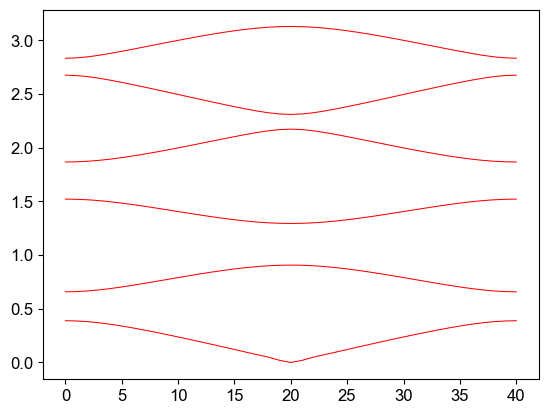

In [27]:

for b in 1:6
    plot([D_te.ωspline[b](ks, 0) for ks in -0.5:0.025:0.5].*2π*c/a*ħeV, color="red")
end
# for b in 1:6
#     plot(D_tm.ωspline[b](ks, 0), color="blue")
# end

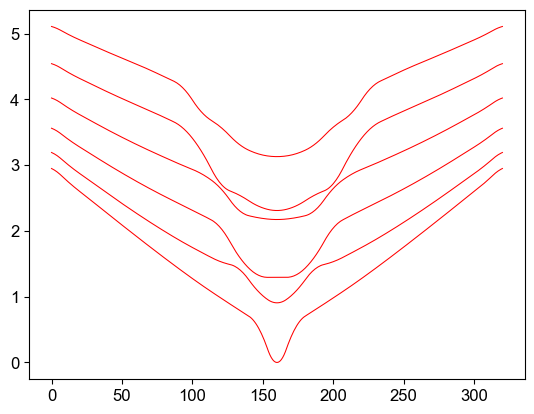

In [38]:
for b in 1:6
    plot([D_te.ωspline[b](0, ks) for ks in -4:0.025:4].*2π*c/a*ħeV, color="red")
end
# for b in 1:6
#     plot(D_tm.ωspline[b](ks, 0).*2π*c/a*ħeV, color="blue")
# end

In [124]:
# analytical angular spectrum
# doesn't really work rn
fspec_1d_a_te = dηdω(75, 3.0, P, D_te, "1D_a", gvec, χ, np, L, Nangles=100, lz=0.6e14, θdev=0.00175, ϕdev=0.00165, pol="te", Nb=6)
fspec_1d_a_tm = dηdω(75, 3.0, P, D_tm, "1D_a", gvec, χ, np, L, Nangles=100, lz=0.6e14, θdev=0.00175, ϕdev=0.00165, pol="tm", Nb=6)

phidev = 0.001976329351549244
θp = 0.4832704800866785
omega i = 1


LoadError: TaskFailedException:
MethodError: no method matching *(::NTuple{16,Int64}, ::Float64)
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::Complex{Bool}, ::Real) at complex.jl:309
  *(!Matched::Bool, ::T) where T<:AbstractFloat at bool.jl:109
  ...
Stacktrace:
 [1] (::var"#586#588"{Int64,Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,Float64})(::Tuple{Float64,Float64}) at ./none:0
 [2] iterate at ./generator.jl:47 [inlined]
 [3] collect(::Base.Generator{Base.Iterators.ProductIterator{Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},var"#586#588"{Int64,Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,Float64}}) at ./array.jl:686
 [4] macro expansion at /home/elinas/Research/xray/xray_3dphc.jl:993 [inlined]
 [5] (::var"#690#threadsfor_fun#587"{Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Float64,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [6] (::var"#690#threadsfor_fun#587"{Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Float64,UnitRange{Int64}})() at ./threadingconstructs.jl:48

In [11]:
Nω=30
fspec_1d_te = dηdω(Nω, 2.5, P, D_te, "1D", gvec, χ, np, L, Nangles=500, lz=1.3e14, θdev=0.00175, ϕdev=0.00175, pol="te", Nb=6)
fspec_1d_tm = dηdω(Nω, 2.5, P, D_tm, "1D", gvec, χ, np, L, Nangles=500, lz=1.3e14, θdev=0.00175, ϕdev=0.00175, pol="tm", Nb=6)

phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30


30-element Array{Float64,1}:
 2.5740416511937594e-25
 4.08968444051249e-24
 1.1317881847373254e-23
 2.264989299058633e-23
 3.9608738271277676e-23
 6.293632034876654e-23
 9.295268819386907e-23
 1.298455135555959e-22
 1.720389447886878e-22
 2.191345339192062e-22
 2.7244854755501524e-22
 3.323879634565149e-22
 3.992720557613621e-22
 ⋮
 9.301793905906518e-22
 1.0378710788008552e-21
 1.1507631639528627e-21
 1.268750964839554e-21
 1.3917337372001598e-21
 1.519660503839594e-21
 1.652235884757754e-21
 1.7891855872627535e-21
 1.9302977538894587e-21
 2.0758086621050423e-21
 2.225611462418335e-21
 2.3740047905972477e-21

In [30]:
fspec_1d_fs_te_m = dηdω(Nω, 3.0, P, D_fs_te, "1D", gvec, χ, np, L, Nangles=500, lz=1.3e14, θdev=0.00175, ϕdev=0.00175, pol="te", Nb=6)
fspec_1d_fs_tm_m = dηdω(Nω, 3.0, P, D_fs_tm, "1D", gvec, χ, np, L, Nangles=500, lz=1.3e14, θdev=0.00175, ϕdev=0.00175, pol="tm", Nb=6)

LoadError: UndefVarError: D_fs_te not defined

In [12]:
fspec_1d_fs_tm = dηdω_free(Nω, 2.5, 12, P, gvec, χ, np, L, Nangles=500, lz=0.6e14, θdev=0.00175, ϕdev=0.00175, pol="tm")
fspec_1d_fs_te = dηdω_free(Nω, 2.5, 12, P, gvec, χ, np, L, Nangles=500, lz=0.6e14, θdev=0.00175, ϕdev=0.00175, pol="te")

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30


([4.28374437907109e-25, 8.05640811730837e-24, 2.417897724980593e-23, 4.929504719835688e-23, 8.353114053170125e-23, 1.269438969148386e-22, 1.7956398098046315e-22, 2.4140915974342544e-22, 3.12489636486041e-22, 3.928106233200719e-22  …  1.8848938513764318e-21, 2.075513052730408e-21, 2.275187779887003e-21, 2.483875499402312e-21, 2.7015248869233553e-21, 2.9280734315155187e-21, 3.1634441507338765e-21, 3.407541003097237e-21, 3.660242343879117e-21, 3.921391354092339e-21], [0.0007752800318151012 0.0007847788112136306 … 0.0007847788112136306 0.0007752800318151012; 0.0007788847301404614 0.0007884796618658166 … 0.0007884796618658166 0.0007788847301404614; … ; 0.0005961169320590478 0.0006034578193517137 … 0.0006034578193517137 0.0005961169320590478; 0.0005939886744977135 0.0006012636831184963 … 0.0006012636831184963 0.0005939886744977135], 7.0140280560848645e-6, 7.334336644618982e-6, 0.2948780647924133:7.0140280561121194e-6:0.29837806479241324)

In [44]:
sum(fspec_1d_fs_tm[2])*fspec_1d_fs_tm[3]*fspec_1d_fs_tm[4]

1.01898582546676e-6

In [45]:
sum(dat2)*Δθ*Δϕ

5.10257609048952e-7

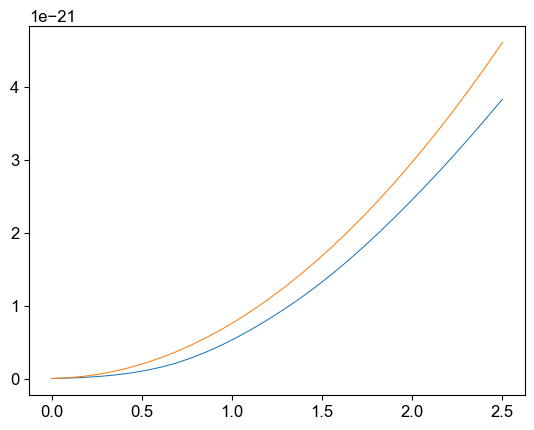

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f72dd035090>

In [14]:
ωrange = range(0, 2.5, length=Nω)
plot(ωrange, (fspec_1d_te .+ fspec_1d_tm))
plot(ωrange, (fspec_1d_fs_tm[1] .+ fspec_1d_fs_te[1])/2)

# xlim(0, 0.5)
# ylim(0,2e-22)

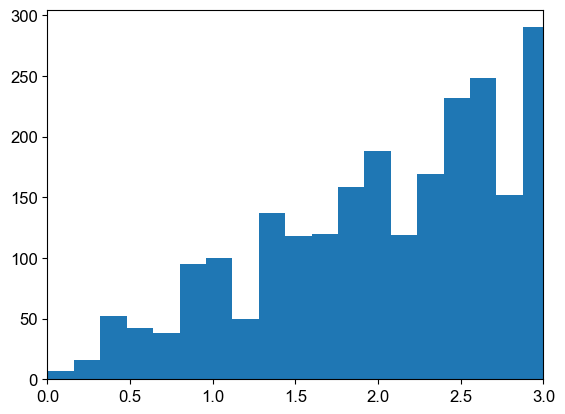

(0.0, 3.0)

In [50]:
# density of states
# plot([8*π*sqrt(12)^3*(ω/(2π))^2/c^3 for ω in 0:0.1/ħeV:3.0/ħeV])
hist(vec(ωdat * 2π*c/a* ħeV), bins=30)
xlim(0, 3)

In [132]:
data = npzread("phc_an_files/phc1d_fs_largek_kpar_tm_ga.npz")
ωdat_fs_tm = data["arr_3"];
data = npzread("phc_an_files/phc1d_fs_largek_kpar_te_ga.npz")
ωdat_fs_te = data["arr_3"];
data = npzread("phc_an_files/phc1d_largek_kpar_tm_ga.npz")
ωdat_tm = data["arr_3"];
data = npzread("phc_an_files/phc1d_largek_kpar_te_ga.npz")
ωdat_te = data["arr_3"];

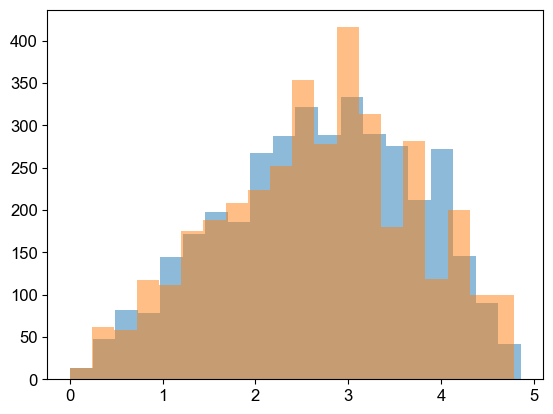

In [135]:
Nbins = 20
dE = maximum(vec(ωdat_fs_tm)) * 2π*c/a* ħeV/Nbins
h_fs_tm = hist(vec(ωdat_fs_tm * 2π*c/a* ħeV), bins=Nbins, alpha=0.5);
# h_fs_te = hist(vec(ωdat_fs_te * 2π*c/a* ħeV), bins=Nbins, alpha=0.5);
h_fs_tm = hist(vec(ωdat_tm * 2π*c/a* ħeV), bins=Nbins, alpha=0.5);
# h_fs_te = hist(vec(ωdat_te * 2π*c/a* ħeV), bins=Nbins, alpha=0.5);

# xlim(0, 3)

In [116]:
minimum(h_tm[2])

0.0

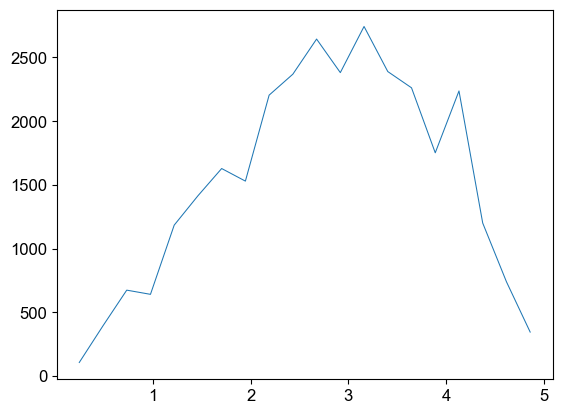

0.0:0.24314823384530482:4.862964676906096

In [138]:
plot(h_tm[2][2:end], h_tm[1]/dE .+ h_te[1]/dE)
Erange = range(0, maximum(h_tm[2]), length=size(h_tm[2])[1])
# plot(Erange, Erange.^2*sqrt(13/2)^3/(π^2*c^3*ħeV^2))

In [98]:
npzwrite("phc_an_files/fspec_fs_1d_ga.npz", fspec_1d_fs)
npzwrite("phc_an_files/fspec_1d_ga.npz", fspec_1d_te .+ fspec_1d_tm)

LoadError: UndefVarError: fspec_1d_fs not defined

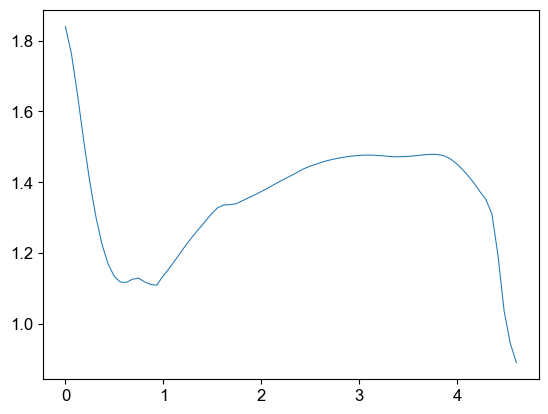

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fee17a2d4d0>

In [160]:
plot(ωrange,(fspec_1d_te .+ fspec_1d_tm)./(fspec_1d_fs))

## Things on top of each other
stacks on stacks on stacks

### Bands

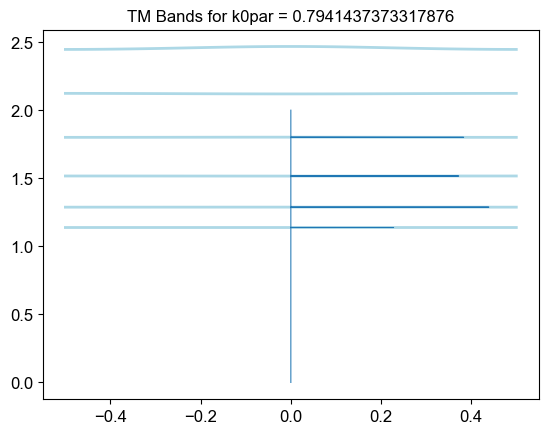

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f754c2c4450>

In [267]:
for b in 1:6
    plot(ks, D_tm.ωspline[b](ks, 2.5), color="lightblue", linewidth=2)
end
ωirange = range(0, 2.0* 2π*c / (a), length=10000)
kip = 2.5*2π/a
kBs = kB_func.(ωirange, kip, 5.3, 1, a/2 , a, "tm")
title("TM Bands for k0par = $(k0parm)")
plot(kBs*a/(2π), ωirange.*a/(2π*c))

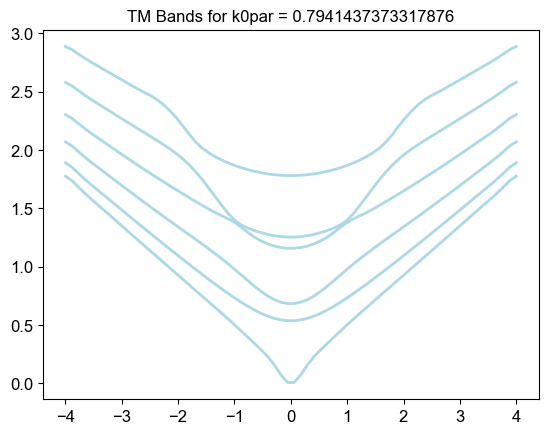

PyObject Text(0.5, 1.0, 'TM Bands for k0par = 0.7941437373317876')

In [264]:
for b in 1:6
    plot(ks.*8, D_tm.ωspline[b](0, ks.*8), color="lightblue", linewidth=2)
end
ωirange = range(0, 2.0* 2π*c / (a), length=1000)
kip = k0parm*2π/a
kBs = kB_func.(ωirange, kip, 5.3, 1, a/2 , a, "tm")
title("TM Bands for k0par = $(k0parm)")
# plot(kBs*a/(2π), ωirange.*a/(2π*c))

In [255]:
#index
println(ωim*a/(2π*c)/2*1000)
println(ωim*a/(2π*c))

205.2815982612497
0.41056319652249945


In [256]:
D_tm.ωspline[b](k0xm, k0parm)

0.4105631965224994

In [257]:
k0xm

-0.03644058019695251

In [254]:
ωirange[208]*a/(2π*c)

0.4144144144144144

In [252]:
kBs[208]*a/(2π)

0.13767606256523254 - 0.0im

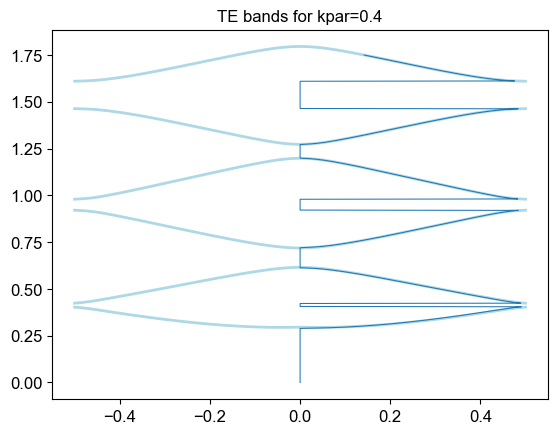

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f069a3e0210>

In [115]:
for b in 1:6
    plot(ks, D_te.ωspline[b](ks, 0.4), color="lightblue", linewidth=2)
end
ωirange = range(0, 1.75* 2π*c / (a), length=1000)
kip = 0.4*2π/a
kBs = kB_func.(ωirange, kip, 5.3, 1, a/2 , a, "te")
title("TE bands for kpar=0.4")
plot(kBs*a/(2π), ωirange.*a/(2π*c))

### Modes

### Modes

In [208]:
numz = 1024
zs = range(0, a*(numz-1)/numz, length=numz)
Δz = zs[2] - zs[1];

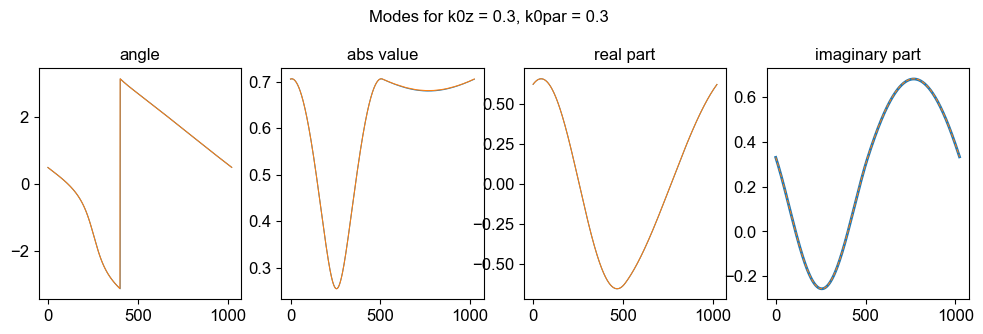

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f06998dfe10>

In [118]:
k0z = 0.3
k0p = 0.3
kip = k0p*2*π/a
band = 2
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
coeffs, n = mode_coeffs_and_norm(ωi,kip,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;

k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
kBc = kB_func(ωi, kip, 5.3, 1, a/2 , a, "tm")
E_1 = npzread("phc_an_files/phc1d_modes_kpar-0.3.npz")["arr_0"]

Δϕf = angle(E_1[band,3,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))

subplots(1,4, figsize=(12,3))
suptitle("Modes for k0z = 0.3, k0par = 0.3", y=1.0745)
subplot(1,4,1)
title("angle")
plot(angle.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf)))
plot(angle.(E_1[band,3,:,1,1]))
subplot(1,4,2)
title("abs value")
plot(abs.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(abs.(E_1[band,3,:,1,1]))
subplot(1,4,3)
title("real part")
plot(real.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(real.(E_1[band,3,:,1,1]))
subplot(1,4,4)
title("imaginary part")
plot(imag.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a), linewidth=2)
plot(imag.(E_1[band,3,:,1,1]), linestyle="dashed")



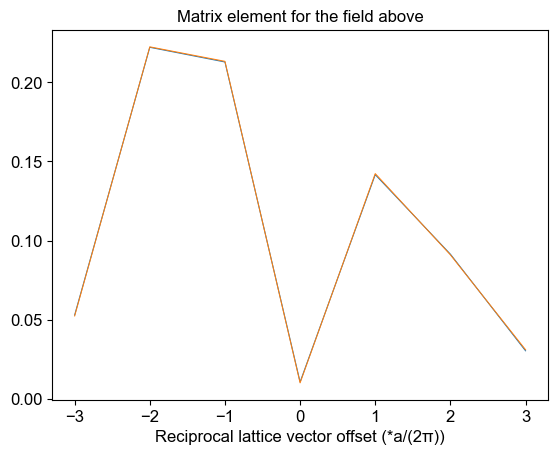

PyObject Text(0.5, 25.078125, 'Reciprocal lattice vector offset (*a/(2π))')

In [236]:
M_1_z = npzread("phc_an_files/phc1d_M_1_z_kpar-0.3.npz")["arr_0"]

plot(range(-3, 3, length=7), [abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="te")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot(range(-3, 3, length=7), M_1_z)
title("Matrix element for the field above")
xlabel("Reciprocal lattice vector offset (*a/(2π))")

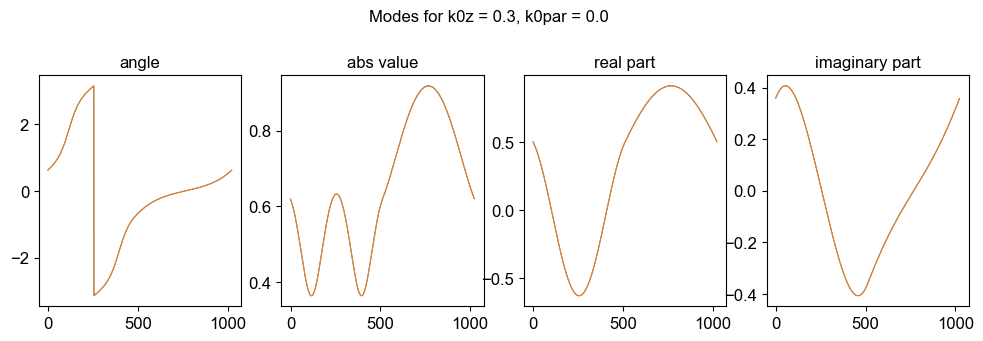

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe2ba4ac4d0>

In [237]:
k0z = 0.3
k0p = 0.0
kip = k0p*2*π/a
band = 3
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
coeffs, n = mode_coeffs_and_norm(ωi,kip,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;
k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
kBc = kB_func(ωi, kip, 5.3, 1, a/2 , a, "tm")
E_1 = npzread("phc_an_files/phc1d_modes.npz")["arr_0"]
Δϕf = angle(E_1[band,2,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))

subplots(1,4, figsize=(12,3))
suptitle("Modes for k0z = 0.3, k0par = 0.0", y=1.1)
subplot(1,4,1)
title("angle")
plot(angle.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf)))
plot(angle.(E_1[band,2,:,1,1]))
subplot(1,4,2)
title("abs value")
plot(abs.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(abs.(E_1[band,2,:,1,1]))
subplot(1,4,3)
title("real part")
plot(real.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(real.(E_1[band,2,:,1,1]))
subplot(1,4,4)
title("imaginary part")
plot(imag.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(imag.(E_1[band,2,:,1,1]))

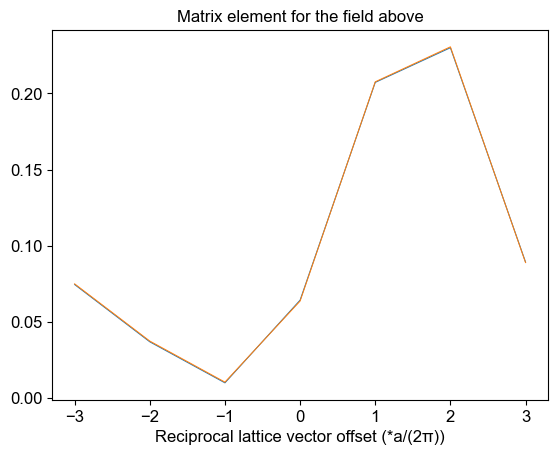

PyObject Text(0.5, 25.078125, 'Reciprocal lattice vector offset (*a/(2π))')

In [239]:
M_1_y = npzread("phc_an_files/phc1d_M_1_y.npz")["arr_0"]
plot(range(-3, 3, length=7), [abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="te")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot(range(-3, 3, length=7), M_1_y)
title("Matrix element for the field above")
xlabel("Reciprocal lattice vector offset (*a/(2π))")

### Mode integrals